# Treinamento

Este código foi efeito baseado na Aula 8 - CNN Classificação: aula08-exemplo01.ipynb

## Importação das pastas de treinamento e teste do dataset

In [ ]:
import kagglehub
import shutil
import os

# 1. Baixar todo o dataset
path = kagglehub.dataset_download("paridhijain02122001/cotton-crop-disease-detection")
print("Path:", path)

# 2. Escolher apenas as pastas desejadas
folders = [
    "train/Army_worm",
    "train/Bacterial_Blight",
    "test/Army_worm",
    "test/Bacterial_Blight"
]

output_dir = "cotton_selected_classes"

os.makedirs(output_dir, exist_ok=True)

for folder in folders:
    src = os.path.join(path, folder)
    dest = os.path.join(output_dir, folder)
    if os.path.exists(src):
        shutil.copytree(src, dest, dirs_exist_ok=True)
        print(f"✅ Copiado: {src} → {dest}")
    else:
        print(f"⚠ Pasta não encontrada: {src}")


100%|██████████| 656M/656M [00:31<00:00, 21.9MB/s]

Extracting files...


Path: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1
✅ Copiado: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/train/Army_worm → cotton_selected_classes/train/Army_worm
✅ Copiado: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/train/Bacterial_Blight → cotton_selected_classes/train/Bacterial_Blight
✅ Copiado: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/test/Army_worm → cotton_selected_classes/test/Army_worm
✅ Copiado: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/test/Bacterial_Blight → cotton_selected_classes/test/Bacterial_Blight


## Importação das bibliotecas

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import tensorflow.keras.utils as np_utils
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from skimage.io import imshow
from sklearn.metrics import classification_report, confusion_matrix # Responsável por devolver o relatório e a matriz de confusão respectivamente
from sklearn.model_selection import train_test_split # Responsável por separar parte das imagens para teste e o restante para treinamento
from sklearn.metrics import ConfusionMatrixDisplay   # Reponsável por exibir a matrix de confusão
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers, models
from imutils import paths # Responsável para achar arquivos de imagens

## Carregando o conteúdo da pasta de treinamento

In [ ]:
#Endereço do diretorio do Dataset
path_dataset = "/content/cotton_selected_classes/train"

#Carrega a lista de labels
label_dict = {}
for i, d in enumerate(sorted(os.listdir(path_dataset))):
    label_dict[d] = i

print(label_dict)

#Calcula a quantidade de classes
num_classes = len(label_dict)

{'Army_worm': 0, 'Bacterial_Blight': 1}


In [ ]:
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(path_dataset)))
random.seed(42)            # Garante que o embaralhamento do caminho das imagens será o mesmo sempre que o código rodar
random.shuffle(imagePaths) # Embaralha randomicamente, previne que o modelo aprenda qualquer padrão baseado na ordem das imagens
print(imagePaths)          # Imprime a lista embaralhada das imagens

['/content/cotton_selected_classes/train/Bacterial_Blight/contrast_14.jpg', '/content/cotton_selected_classes/train/Army_worm/aug_0_constract_high_38.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/aug_1_translation_14.jpg', '/content/cotton_selected_classes/train/Army_worm/aug_1_33.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/32.jpg', '/content/cotton_selected_classes/train/Army_worm/aug_0_crop_37.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/rotation_14.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/aug_1_flip_horizontal_11.jpg', '/content/cotton_selected_classes/train/Army_worm/aug_0_flip_6.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/aug_0_crop_8.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/pil_sharpness_zoom_15.jpg', '/content/cotton_selected_classes/train/Bacterial_Blight/constract_high_zoom_18.jpg', '/content/cotton_selected_classes/train/Army_worm/aug_0_translation_20.jpg', '/c

## Etapa de pré-processamento

In [ ]:
# Iniciamos uma variável para armazenar as classes de cada imagem
labels = []
# Iniciamos uma variável para armazenar as imagens
data = []

print("[INFO] loading images...")
for imagePath in tqdm(imagePaths):
    # tqdm é usado para mostrar a barra de progresso enquanto as imagens são processadas
    # Carrega a imagem, faz o pré-processamento dela e armazena na lista de dados
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64)) # Redimensiona a imagem carregada para terem tamanhos consistentes
    image = img_to_array(image) # Converte a imagem para um formato de array Numpy (isso é necessário para o processamento de imagens com bibliotecas como o Tensorflow)
    data.append(image)  # Acrescenta ao data

    # Extrai a classe do caminho da imagem e atualiza a lista de "labels"
    label = label_dict[imagePath.split(os.path.sep)[-2]]
    labels.append(label)

[INFO] loading images...


100%|██████████| 2880/2880 [00:03<00:00, 907.87it/s] 


## Preparação para o treinamento da rede neural
Depois de rodar essa célula, o dados estarão prontos para alimentar a rede neural para treinamento e avaliação.

In [ ]:
# Dimensiona a intesidade dos pixel brutos para intensidades na escla [0, 1]
# Essa normalização é uma prática comum em processamento de imagens para redes neurais pois ajuda a aprimorar a peformance do treinamento
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Essa etapa divide o dataset em 75% para treinamento e 25% para teste (crucial para ML)
(train_images, test_images, train_l, test_l) = train_test_split( data, labels, test_size=0.25, random_state=42, stratify=labels)

# convert the labels from integers to vectors
train_labels = np_utils.to_categorical(train_l, num_classes=num_classes)
test_labels = np_utils.to_categorical(test_l, num_classes=num_classes)

In [ ]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2160, 64, 64, 3) (2160, 2)
(720, 64, 64, 3) (720, 2)


### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation aplicado SOMENTE ao conjunto de treino
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotaciona levemente as imagens
    width_shift_range=0.1,    # Deslocamento horizontal
    height_shift_range=0.1,   # Deslocamento vertical
    horizontal_flip=True,     # Espelhamento horizontal
    zoom_range=0.1            # Pequeno zoom
)
datagen.fit(train_images)     # Ajusta no dataset de treino

### Visualização de algumas imagens de treinamento

Essa parte do código ajuda a visualizar uma amostra dos dados de treinamento e a confirmar que as imagens estão sendo carregadas corretamente e que os rótulos são apropriados.

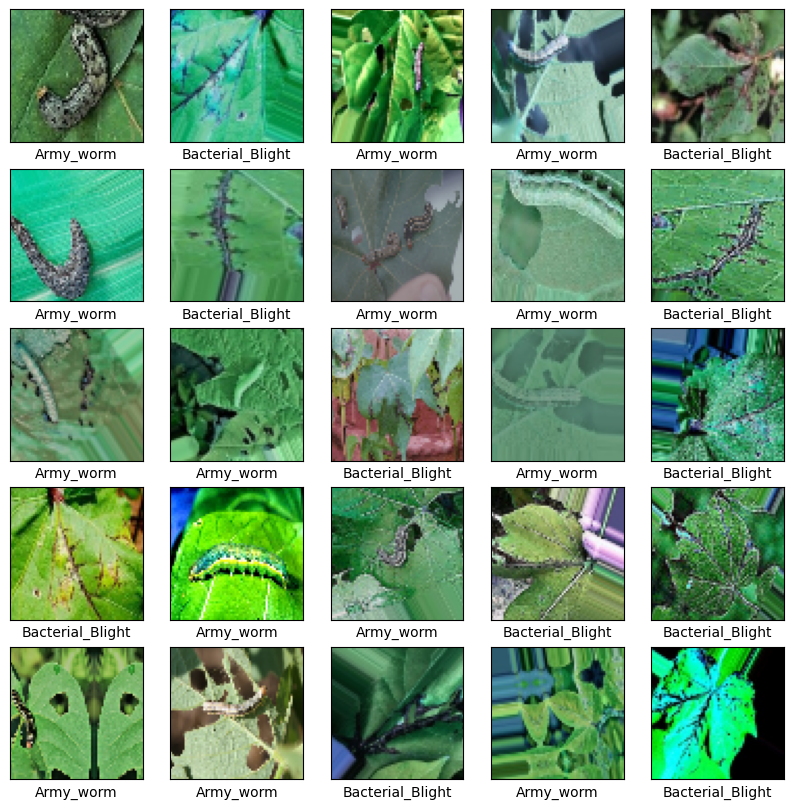

In [ ]:
plt.figure(figsize=(10,10)) # Cria as figuras com imagens reduzida
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_float32 = np.float32(train_images[i])
    plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)) # Converte do formato usado pelo OpenCV (BGR) para o usado pelo Matplot (RGB)
    # labels
    plt.xlabel( [k for k, v in label_dict.items() if v == train_l[i]][0] )
plt.show()

In [ ]:
data.shape

(2880, 64, 64, 3)

## CNN (Rede convolucional)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,354 (2.61 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Compilação e treinamento do modelo

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_l, epochs=50, batch_size=5,
                    validation_data=(test_images, test_l))

Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6671 - loss: 1.2618 - val_accuracy: 0.7306 - val_loss: 0.5686
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8165 - loss: 0.4239 - val_accuracy: 0.8444 - val_loss: 0.3588
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8425 - loss: 0.3726 - val_accuracy: 0.8167 - val_loss: 0.3621
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8569 - loss: 0.3106 - val_accuracy: 0.7806 - val_loss: 1.0074
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8701 - loss: 0.3127 - val_accuracy: 0.8097 - val_loss: 0.4068
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9066 - loss: 0.2246 - val_accuracy: 0.8056 - val_loss: 0.4878
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9150 - loss: 0.2196 - val_accuracy: 0.8583 - val_loss: 0.3775
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9347 - loss: 0.1691 - val_accuracy: 0

### Acurácia de treinamento e de validação

In [ ]:
# Print training and validation accuracy
print(f"Acurácia de treinamento: {history.history['accuracy'][-1]*100:.2f}%")   # Mostra o percentual de imagens que a rede classificou corretamente do conjunto de treinamento
print(f"Acurácia de validação: {history.history['val_accuracy'][-1]*100:.2f}%") # Mostra o percentual de acertos no conjunto teste/validação (mostra se ele consegue gerneralizar ou não)

Acurácia de treinamento: 98.52%
Acurácia de validação: 87.50%


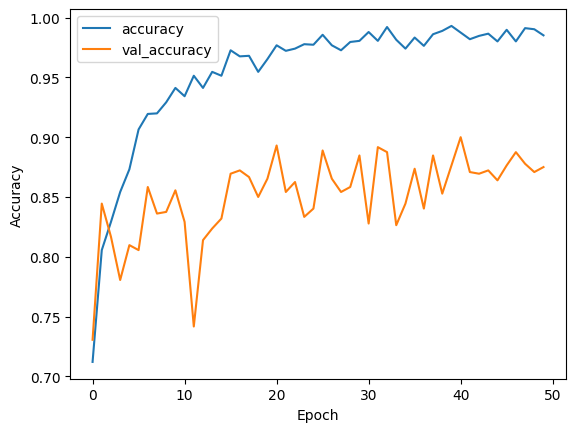

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

## Fazendo as predições no conjunto de testes do treinamento

In [ ]:
# Predições
print("Generating test predictions...")
predict_x = model.predict(test_images)

# Transformar em classes
y_pred_class = np.argmax(predict_x, axis=1)
y_test_class = test_l

# Mostrar previsões com acerto/erro
for i in range(len(y_test_class)): # Use y_test_class (which is now test_l) for loop range
    if y_pred_class[i] == y_test_class[i]:
        print(f'\033[92m Pred: {y_pred_class[i]} (Expected {y_test_class[i]}) ✅')
    else:
        print(f'\033[91m Pred: {y_pred_class[i]} (Expected {y_test_class[i]}) ❌')

Generating test predictions...
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
 Pred: 1 (Expected 1) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 1) ❌
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 1) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 1) ✅
 Pred: 1 (Expected 1) ✅
 Pred: 0 (Expected 1) ❌
 Pred: 1 (Expecte

### Acurácia de predição e relatório de desempenho

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"\n🎯 Acurácia de teste: {accuracy * 100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=label_dict.keys()))


🎯 Acurácia de teste: 87.50%

📊 Classification Report:
                  precision    recall  f1-score   support

       Army_worm       0.92      0.82      0.87       360
Bacterial_Blight       0.84      0.93      0.88       360

        accuracy                           0.88       720
       macro avg       0.88      0.88      0.87       720
    weighted avg       0.88      0.88      0.87       720



### Matriz de confusão

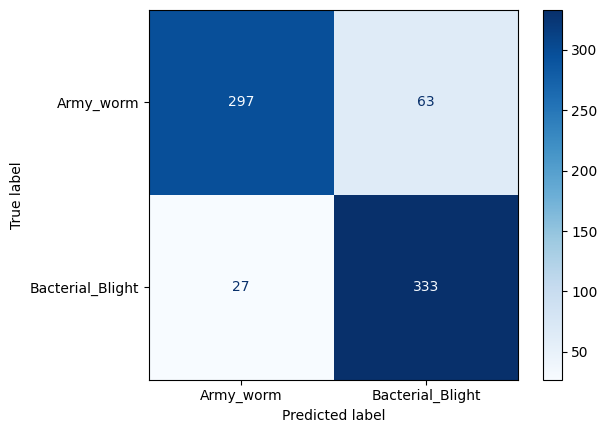

In [ ]:
# voltando pro formato de classes
y_pred = y_pred_class
y_test_c = y_test_class

#Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_dict.keys()))
disp.plot(cmap=plt.cm.Blues)

# TP,   FP  ,  FN,   TN

### Salvando o treinamento no formato H5

In [ ]:
model.save('/content/modelo.h5')

## Utilizando o conteúdo da pasta de teste
fazendo o carregamento e o pré-processamento das imagens de teste para fazer um teste realistico do modelo

In [ ]:
import tensorflow as tf

test_path = "/content/cotton_selected_classes/test"

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

Found 240 files belonging to 2 classes.


### Avaliando a acurácia com os dados da pasta de teste

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4451 - loss: 662.6403
Acurácia no conjunto de teste: 62.92%


### Fazer previsões (predições das classes de cada imagem)

In [ ]:
import numpy as np

# Predições
print("Generating test predictions...")
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Verdadeiras classes (labels reais das imagens)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Mostrar previsões com acerto/erro
for i in range(len(true_labels)): # Use true_labels (which is now test_l) for loop range
    if predicted_classes[i] == true_labels[i]:
        print(f'\033[92m Pred: {predicted_classes[i]} (Expected {true_labels[i]}) ✅')
    else:
        print(f'\033[91m Pred: {predicted_classes[i]} (Expected {true_labels[i]}) ❌')

Generating test predictions...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 0) ❌
 Pred: 0 (Expected 0) ✅
 Pred: 1 (Expected 0) ❌
 Pred: 1 (Expected 

#### Caso queira prever apenas uma imagem

In [ ]:
# from tensorflow.keras.preprocessing import image
# import numpy as np

# img_path = "/content/cotton_selected_classes/test/diseased/0001.jpg"
# class_names = test_dataset.class_names

# img = image.load_img(img_path, target_size=(32, 32))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0) / 255.0

# prediction = model.predict(img_array)
# predicted_class = np.argmax(prediction)

# print("Classe prevista:", class_names[predicted_class])

### Acurácia de predição e relatório de desempenho

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, predicted_classes)
print(f"\n🎯 Acurácia de teste: {accuracy * 100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(predicted_classes, true_labels, target_names=label_dict.keys()))


🎯 Acurácia de teste: 62.92%

📊 Classification Report:
                  precision    recall  f1-score   support

       Army_worm       0.28      0.92      0.43        37
Bacterial_Blight       0.97      0.58      0.72       203

        accuracy                           0.63       240
       macro avg       0.63      0.75      0.58       240
    weighted avg       0.87      0.63      0.68       240



### Matriz de confusão

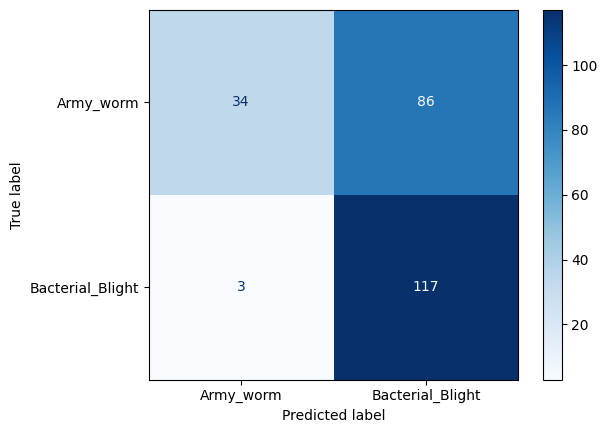

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_dict.keys()))
disp.plot(cmap=plt.cm.Blues)

# TP,   FP  ,  FN,   TN

# Teste do modelo com imagens externas

Este código foi efeito baseado na Aula 8 - CNN Classificação: aula08-exemplo02.ipynb

## Importação da bibliotecas

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, models

## Carregamento das imagens externas

In [ ]:
data = []
image = cv2.imread("cotton_leaf_worm.png")
image = cv2.resize(image, (64, 64))
data.append(image)
image = cv2.imread("cotton_leaf_disease.jpg")
image = cv2.resize(image, (64, 64))
data.append(image)
data = np.array(data, dtype="float") / 255.0
data.shape

(2, 64, 64, 3)

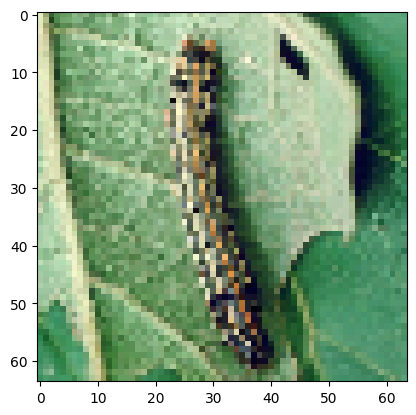

In [ ]:
img_float32 = np.float32(data[0])
plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB) )

## Teste de confiança do modelo

In [ ]:
print("Generating test predictions...")
predict_x=model.predict(data)
print(np.around(predict_x, 2))

# make class predictions
predictions = (predict_x > 0.5).astype(int)

Generating test predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
[[1. 0.]
 [0. 1.]]


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,052,168 (7.83 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,367,814 (5.22 MB)